# Investigating on Heavy Traffic Indicators on I-94

We're going to analyze a dataset about the westbound traffic on the I-94 Interstate highway. Link[https://en.wikipedia.org/wiki/Interstate_94]

John Hogue made the dataset available, and you can download it from the UCI Machine Learning Repository. Link[https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume]

The goal of our analysis is to determine a few indicators of heavy traffic on I-94. These indicators can be weather type, time of the day, time of the week, etc. For instance, we may find out that the traffic is usually heavier in the summer or when it snows.

The goal of our analysis is to determine a few indicators of heavy traffic on I-94 from the Link[https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume] dataset by John Hogue.

Hourly Minneapolis-St Paul, MN traffic volume for westbound I-94. Includes weather and holiday features from 2012-2018.

The dataset documentation mentions that a station located approximately midway between Minneapolis and Saint Paul recorded the traffic data. Also, the station only records westbound traffic (cars moving from east to west).

We start with an initial look into the dataset using `DateFrame.info()`.

1. Read in the Metro_Interstate_Traffic_Volume.csv file using Pandas.
2. Examine the first and the last five rows.
3. Use DataFrame.info() to find more information about the dataset.


In [8]:
import pandas as pd

interstate_traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

print(interstate_traffic.head())
print(interstate_traffic.tail())

  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918  
      holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0   

### Initial Observations
We noted that there are 48204 entries and 9 columns. All the columns have 48204 entries, no null values. The dataset has a mix of objects, float, and int datatypes.

1. Convert datetime to a date dtype to derive meaningful time based analysis.

In [9]:
interstate_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


## Analyzing traffic volume distribution

Use matplotlib to generate a histogram.

On the previous screen, we read in the dataset and set our analysis goal: determine indicators of heavy traffic on I-94.

The dataset documentation Link[https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume] mentions that a station located approximately midway between Minneapolis and Saint Paul recorded the traffic data. Also, the station only records westbound traffic (cars moving from east to west).

Image[https://s3.amazonaws.com/dq-content/524/i94_figma.png]
This means that the results of our analysis will be about the westbound traffic in the proximity of that station. In other words, we should avoid generalizing our results for the entire I-94 highway.

In the next exercise, we're going to plot a histogram to visualize the distribution of the traffic_volume column.

When we use Matplotlib inside Jupyter, we also need to add the %matplotlib inline magic — this enables Jupyter to generate the graphs.

```import matplotlib.pyplot as plt
%matplotlib inline
​
plt.plot()
plt.show()```

We only need to run %matplotlib inline once inside a notebook. If we have a notebook with ten cells, and we plot a graph in each cell, it's enough to add %matplotlib inline in the first cell.

Instructions
Add the %matplotlib inline magic.
Plot a histogram to examine the distribution of the traffic_volume column. Use a Pandas method.
Use Series.describe() to look up a few statistics about the traffic_volume column.
Note a few observations about the distribution of traffic_volume based on the histogram and the result of Series.describe().
Do you think daytime and nighttime influence the traffic volume?

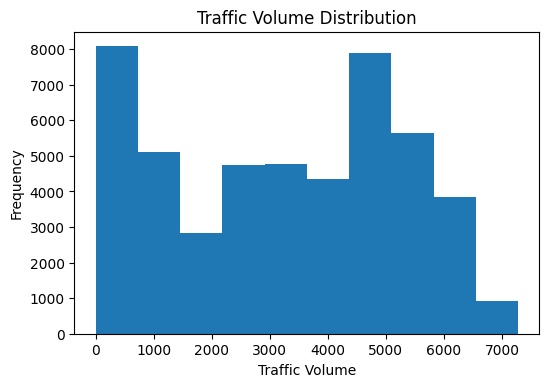

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot a histogram
interstate_traffic['traffic_volume'].plot.hist()
plt.xlabel('Traffic Volume')
plt.title('Traffic Volume Distribution')
plt.show()

# Generate statistics about traffic_volume
interstate_traffic['traffic_volume'].describe()

- The bulk of our traffic volume is be between 0-500 (8000) and 4500-5000 (8000) with the median 3380. The traffic varies between 0 and 7,280 vehicles.

About 25% of the time, the traffic volume was 1,193 or fewer each hour, probably during night time. About 25 % of the time, the traffic volume is roughly 4 times (4933), probably during busy hours or holidays.

## Day Traffic Vs. Night Traffic

We'll start by dividing the dataset into two parts:

Daytime data: hours from 7 a.m. to 7 p.m. (12 hours)
Nighttime data: hours from 7 p.m. to 7 a.m. (12 hours)

In [42]:
interstate_traffic['date_time'] = pd.to_datetime(interstate_traffic['date_time'])

day_bool = (interstate_traffic['date_time'].dt.hour >= 7) & (interstate_traffic['date_time'].dt.hour < 19)
night_bool = (interstate_traffic['date_time'].dt.hour >= 19) | (interstate_traffic['date_time'].dt.hour < 7)

day_traffic = interstate_traffic.copy()[day_bool]
print(day_traffic.shape)

night_traffic = interstate_traffic.copy()[night_bool]
print(night_traffic.shape)

(23877, 9)
(24327, 9)


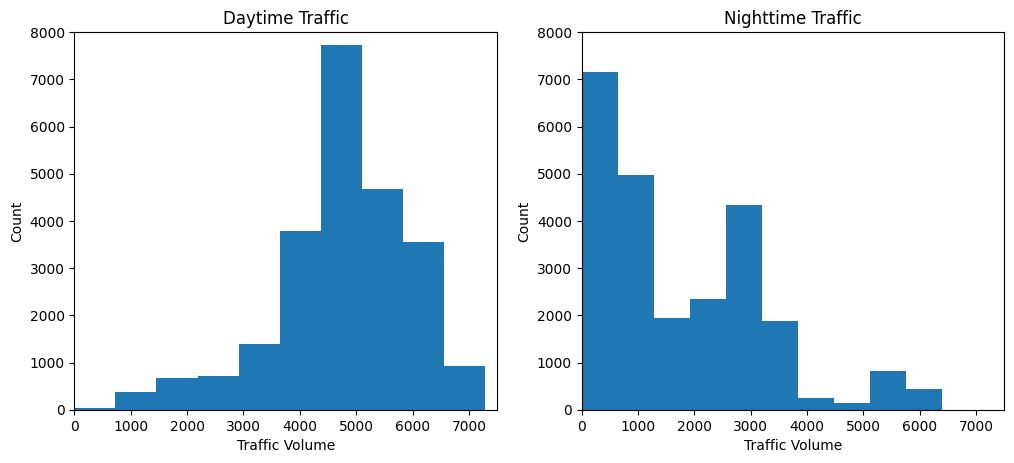

In [43]:
# Plot Histogram of trafic_volume for both day and night

plt.figure(figsize=(12, 5))
 
for i in range(1, 3):
    plt.subplot(1, 2, i)
    
    if i == 1:
        day_traffic['traffic_volume'].plot.hist()
        plt.title('Daytime Traffic')
    else:
        night_traffic['traffic_volume'].plot.hist()
        plt.title('Nighttime Traffic')
        
    plt.xlabel('Traffic Volume')
    plt.ylabel('Count')
    plt.xlim(0, 7500)
    plt.ylim(0, 8000)
    
plt.show()

In [44]:
day_traffic['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [45]:
night_traffic['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

### Observations

What shape do the histograms have and what does that indicate?
Day: Almost a normal distribution, indicating values are distributed equally before and after the median (4,820). Highest count being 8000 cases where traffic was 5000 cars in an hour passing in the station.

Night: Right-skewed distribution, the traffic volume at night is mostly in the left extremety (indicating that bulk of nighttime traffic is fewer). Most between 0-500 (7000 counts)

If the traffic is light at night, and our goal is to find indicators of heavy traffic, should we still be using the nighttime data?

- Our goal is to find indicators of heavy traffic, so we'll only focus on the daytime data moving forward.

# Time Indicators

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day.

We're going to look at a few line plots showing how the traffic volume changed according to the following parameters:

* Month
* Day of the week
* Time of day

In [55]:
# Isolate month and group by month

day_traffic['month'] = day_traffic['date_time'].dt.month

mean_by_month = day_traffic.groupby('month').mean()

# Monthly traffic Volume Avgs
mean_by_month['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

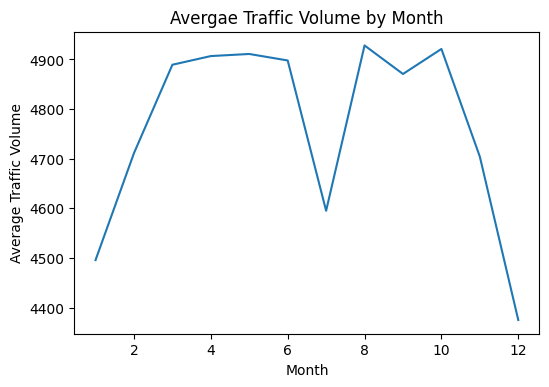

In [61]:
# Generate a line plot to visualize how the traffic volume changed each month on average

mean_by_month['traffic_volume'].plot.line()

plt.title('Avergae Traffic Volume by Month')
plt.xlabel('Month')
plt.ylabel('Average Traffic Volume')

plt.show()

### Some INteresting Observations to Note

Traffic Volume decreases (takes a nose dive) significantly in winter months. 4900 in Oct to 4400 in Dec (x% decrease), Rising up in March.

- exception: Dec. in July. Why?

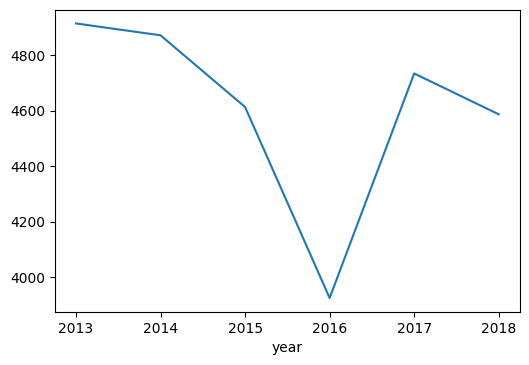

In [67]:
july_traffic = day_traffic.copy()[day_traffic['month'] == 7]
july_traffic['year'] = july_traffic['date_time'].dt.year

july_traffic.groupby('year').mean()['traffic_volume'].plot.line()

plt.show()

Typically, the traffic is pretty heavy in July, similar to the other warm months. The only exception we see is 2016, which had a high decrease in traffic volume. One possible reason for this is road construction — this article from 2016 supports this hypothesis.

As a tentative conclusion here, we can say that warm months generally show heavier traffic compared to cold months. In a warm month, you can can expect for each hour of daytime a traffic volume close to 5,000 cars.

## Analyze by Day of the Week

To get the traffic volume averages for each day of the week,

In [70]:
day_traffic['dayofweek'] = day_traffic['date_time'].dt.dayofweek

avg_by_dayofweek = day_traffic.groupby('dayofweek').mean()

avg_by_dayofweek['traffic_volume'] 
# 0 - Mon, 6 - Sun

dayofweek
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

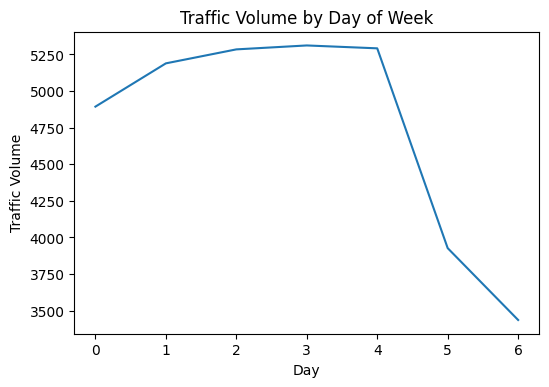

In [74]:
avg_by_dayofweek['traffic_volume'].plot.line()

plt.title('Traffic Volume by Day of Week')
plt.xlabel('Day')
plt.ylabel('Traffic Volume')

plt.show()

Peaks at Friday. Traffic volume is significantly heavier on business days (Monday – Friday). Except for Monday, we only see values over 5,000 during business days. Traffic is lighter on weekends, with values below 4,000 cars. 

Lowest on Sundays.

## Volume by Time of the day

We'll now generate a line plot for the time of day. The weekends, however, will drag down the average values, so we're going to look at the averages separately. To do that, we'll start by splitting the data based on the day type: business day or weekend.

In [85]:
day_traffic['hour'] = day_traffic['date_time'].dt.hour

weekdays_traffic = day_traffic.copy()[day_traffic['dayofweek'].between(0, 4)]

weekend_traffic = day_traffic[day_traffic['dayofweek'] >= 5]

avg_by_hour_weekdays = weekdays_traffic.groupby('hour').mean()

avg_by_hour_weekend = weekend_traffic.groupby('hour').mean()

print(avg_by_hour_weekdays['traffic_volume'].describe())
print('\n')
print(avg_by_hour_weekdays['traffic_volume'].describe())

count      12.000000
mean     5192.498812
std       615.622781
min      4378.419118
25%      4799.891475
50%      5024.132518
75%      5640.880110
max      6189.473647
Name: traffic_volume, dtype: float64


count      12.000000
mean     5192.498812
std       615.622781
min      4378.419118
25%      4799.891475
50%      5024.132518
75%      5640.880110
max      6189.473647
Name: traffic_volume, dtype: float64


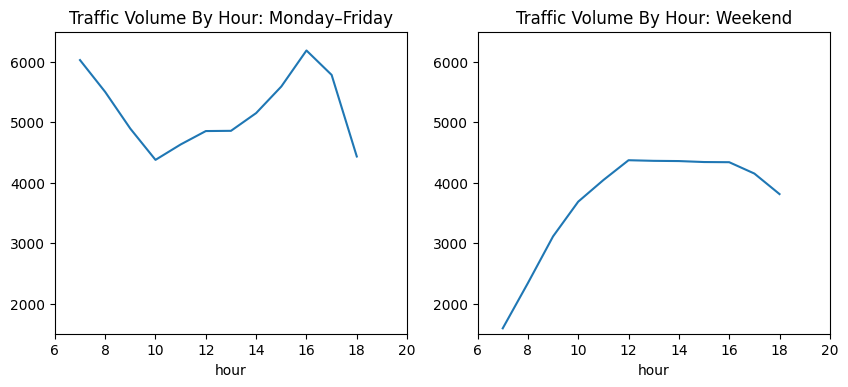

In [97]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
avg_by_hour_weekdays['traffic_volume'].plot.line()
plt.xlim(6,20)
plt.ylim(1500,6500)
plt.title('Traffic Volume By Hour: Monday–Friday')

plt.subplot(1, 2, 2)
avg_by_hour_weekend['traffic_volume'].plot.line()
plt.xlim(6,20)
plt.ylim(1500,6500)
plt.title('Traffic Volume By Hour: Weekend')


plt.show()

Analyze both charts. How do they compare? When are the rush hours on business days?


Summarize all your findings regarding time indicators for heavy traffic.

## Weather Indicators

we reached the following conclusions:

The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
The traffic is usually heavier on business days compared to weekends.
On business days, the rush hours are around 7 and 16.

Another possible indicator of heavy traffic is weather. The dataset provides us with a few useful columns about weather: temp, rain_1h, snow_1h, clouds_all, weather_main, weather_description.

A few of these columns are numerical so let's start by looking up their correlation values with traffic_volume.

In [101]:
# Correlation Coefieciene (Gaussain's) between  traffic and weather

# weather_traffic = day_traffic.copy.drop(['month'])

weather_traffic = day_traffic.copy()

weather_traffic.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
dayofweek        -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

Maybe temp nothing strong correlations.

Let's generate a scatter plot to visualize the correlation between temp and traffic_volume.

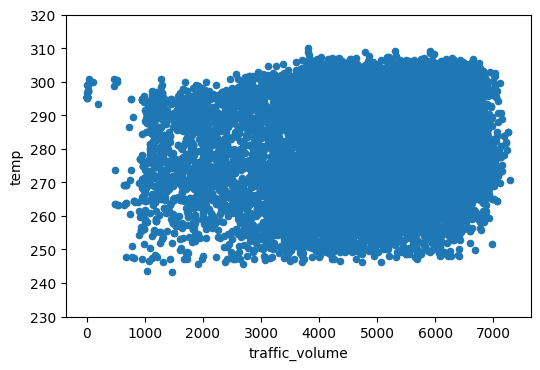

In [106]:
# Scatter Plot
weather_traffic.plot.scatter(x='traffic_volume', y='temp')
plt.ylim(230, 320)
plt.show()


## Weather Types

We can conclude that temperature doesn't look like a solid indicator of heavy traffic.

Let's now look at the other weather-related columns: weather_main and weather_description

However, we didn't find any reliable indicator of heavy traffic.

To see if we can find more useful data, we'll look next at the categorical weather-related columns: weather_main and weather_description.

We're going to calculate the average traffic volume associated with each unique value in these two columns.

In [108]:
by_weather_main = day_traffic.groupby('weather_main').mean()
by_weather_description = day_traffic.groupby('weather_description').mean()

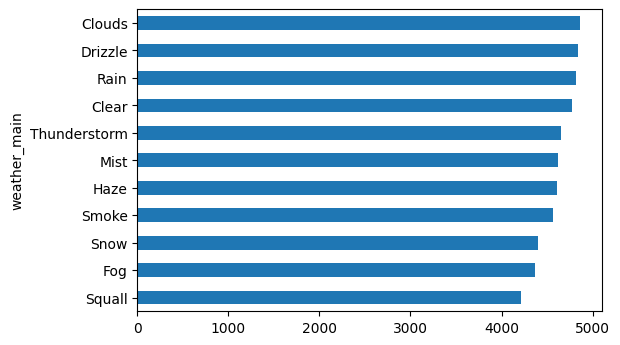

In [111]:
# Bar Plot

by_weather_main['traffic_volume'].sort_values().plot.barh()
plt.show()

It looks like there's no weather type where traffic volume exceeds 5,000 cars. This makes finding a heavy traffic indicator more difficult. Let's also group by weather_description, which has a more granular weather classification.


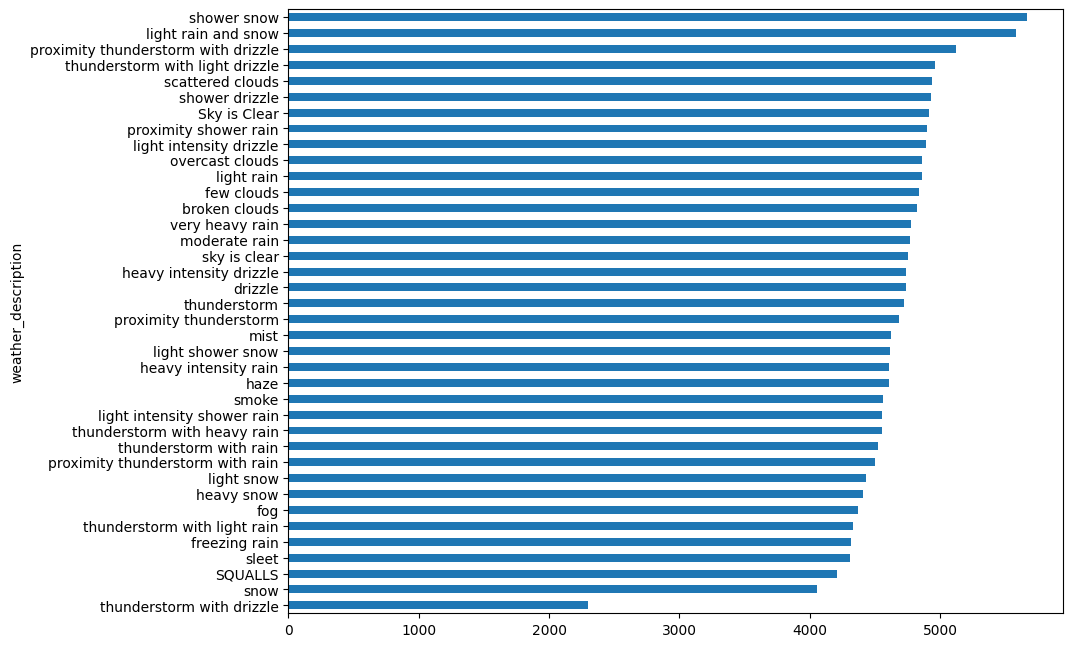

In [117]:
# Bar Plot

plt.figure(figsize=(10, 8))
by_weather_description['traffic_volume'].sort_values().plot.barh()
plt.show()

It looks like there are three weather types where traffic volume exceeds 5,000:

Shower snow
Light rain and snow
Proximity thunderstorm with drizzle
It's not clear why these weather types have the highest average traffic values — this is bad weather, but not that bad. Perhaps more people take their cars out of the garage when the weather is bad instead of riding a bike or walking.

# Conclusion

In this project, we tried to find a few indicators of heavy traffic on the I-94 Interstate highway. We managed to find two types of indicators:

Time indicators
The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
The traffic is usually heavier on business days compared to the weekends.
On business days, the rush hours are around 7 and 16.
Weather indicators
Shower snow
Light rain and snow
Proximity thunderstorm with drizzle
Next steps include the following:

Use the nighttime data to look for heavy traffic indicators.
Find more time and weather indicators.
Make your project portfolio-ready by following this style guide.
Find more time and weather indicators.
Make your project portfolio-ready by following this style guide.